# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `25`
* Students: `Valentin Viennot`

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Utils functions

In [2]:
def are_matrix_equals(a1, a2):
    if a1.shape != a2.shape:
        return False
    for index in np.ndindex(a1.shape):
        if a1[index] != a2[index]:
            return False
    return True

In [3]:
def array_map(f, *x):
    return np.array(list(map(f,*x)))

In [4]:
def is_matrix_symmetric(a):
    differences = np.count_nonzero(A_citation - A_citation.transpose())
    return differences == 0

In [5]:
def get_index_of_1D(array, element):
        i, = np.where(array == element)
        return i

In [6]:
def prune_ids_adjacency_matrix(matrix, ids):
    pruned = np.delete(matrix, ids, axis=0)
    pruned = np.delete(pruned, ids, axis=1)
    return pruned

In [7]:
def unzip(zipped):
    return [ i for i, _ in zipped ], [ j for _, j in zipped ]

In [8]:
def clean_diagonal(matrix):
    for i in range(matrix.shape[0]):
        matrix[i,i] = 0
    return matrix

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [9]:
column_list = ['uid']
features_names = []
for i in range(1433):
    feature = 'w{}'.format(i)
    column_list.append(feature)
    features_names.append(feature)
column_list.append('Label')
df = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list)
df.set_index('uid')
df.head()

,uid,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,Label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [10]:
df.Label.value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: Label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [11]:
my_field = 'Neural_Networks'
filtered_data = df[df.Label == my_field]
features = filtered_data[features_names].values
features.shape

(818, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [12]:
def euclidean_distance_vectors(a, b):
    return np.linalg.norm(a-b)

def euclidean_distance_matrix(features_matrix):    
    matrix = [[euclidean_distance_vectors(a,b) for b in features_matrix] for a in features_matrix]
    return np.array(matrix)
    
distance = euclidean_distance_matrix(features)
distance.shape

(818, 818)

In [13]:
# This is only used to check our results
#from scipy.spatial.distance import pdist, squareform
#d = squareform(pdist(features, metric='euclidean'))
#print('Validation:',are_matrix_equals(d, distance))
#print('Mean is {}'.format(d.mean()))

Check the mean pairwise distance $\mathbb{E}[D]$.

In [14]:
mean_distance = distance.mean()
mean_distance

5.689638434824233

Plot an histogram of the euclidean distances.

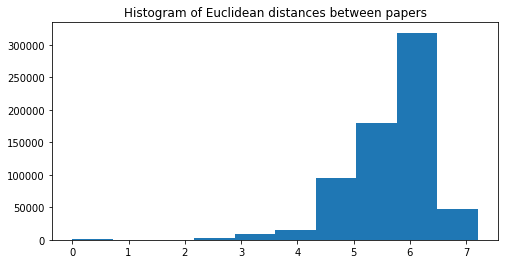

In [15]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [16]:
def binary_threshold_matrix(matrix, threshold):
    ''' returns a copy of the input matrix with values set to 1 if under threshold, 0 otherwise'''
    t = np.copy(matrix)
    t[t > threshold] = 0
    t[t > 0] = 1
    return t

In [17]:
threshold = mean_distance
A_feature = clean_diagonal(binary_threshold_matrix(distance, threshold))
#print('Shape:', A_feature.shape)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [18]:
def create_adjacency_matrix(edges, directed = False):
    nodes = np.unique(edges, axis=None)
    nodes_size = nodes.shape[0]
    a = np.zeros((nodes_size, nodes_size))
    for edge in edges:
        id1 = get_index_of_1D(nodes, edge[0])
        id2 = get_index_of_1D(nodes, edge[1])
        a[id1,id2] = 1
        if not directed:
            a[id2,id1] = 1
    return clean_diagonal(a)

In [19]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

A_citation = create_adjacency_matrix(cora_cites)
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [20]:
filtered_uids = filtered_data['uid'].values
filtered_ids = array_map(lambda uid: get_index_of_1D(filtered_uids, uid),filtered_uids)

pruned_A = prune_ids_adjacency_matrix(A_citation, filtered_ids)
A_citation = pruned_A


Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [21]:
print(is_matrix_symmetric(A_citation))

True


## <span style="color:red">TODO: why do we do symmetric matrix? Althought it should be (?) a directed graph?</span>

Check the shape of your adjacency matrix again.

In [22]:
A_citation.shape

(1890, 1890)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [23]:
def count_edges(adjacency_matrix, directed = False):
    count = np.count_nonzero(adjacency_matrix)
    if directed:
        return count
    return count/2

In [24]:
num_edges_feature = count_edges(A_feature)
num_edges_citation = count_edges(A_citation)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 136763.0
Number of edges in the citation graph: 1395.0


Plot the degree distribution histogram for each of the graphs.

In [25]:
def compute_nodes_degrees(adjacency_matrix, directed = False):
    if directed:
        raise NotImplementedError
    return np.sum(adjacency_matrix, axis=0)

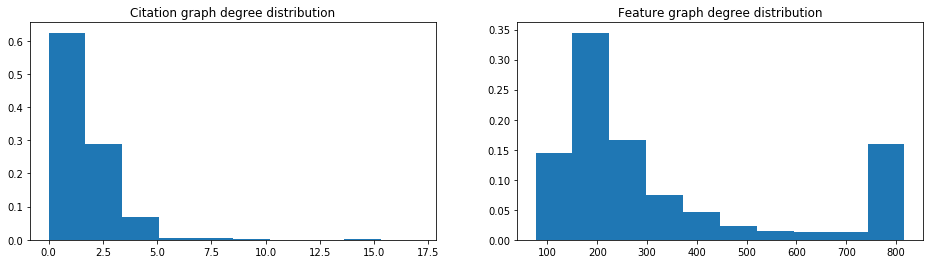

In [26]:
degrees_citation = compute_nodes_degrees(A_citation)
degrees_feature = compute_nodes_degrees(A_feature)

deg_hist_normalization_cit = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]
deg_hist_normalization_feat = np.ones(degrees_feature.shape[0]) / degrees_feature.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization_cit);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization_feat);

Calculate the first and second moments of the degree distribution of each graph.

In [27]:
def compute_nth_moment(adjacency_matrix, degree = 1, directed = False, center = 0):
    nodes_degrees = compute_nodes_degrees(adjacency_matrix, directed)
    nodes_degrees_t = array_map(lambda x: (x-center)**degree, nodes_degrees)
    return np.sum(nodes_degrees_t)/adjacency_matrix.shape[0]

In [28]:
cit_moment_1 = compute_nth_moment(A_citation, 1)
cit_moment_2 = compute_nth_moment(A_citation, 2, center = cit_moment_1)

feat_moment_1 = compute_nth_moment(A_feature, 1)
feat_moment_2 = compute_nth_moment(A_feature, 2, center = feat_moment_1)

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 1.4761904761904763
2nd moment of citation graph: 2.504459561602418
1st moment of feature graph: 334.3838630806846
2nd moment of feature graph: 55380.5568056145


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**    
The first moment (raw, center = 0) is the average degree: It tells us how connected is the network.    
0 -- --> num_edges    
isolated one-node-components -- --> one giant component  
    
The second moment (central, center = mean) is the degree variance: It it tells us how sparse is the network.
    
It is well represented with the degree distribution:    
1. Citation Graph: all nodes are about the same degree (low variance), and the graph is not very connected (low average)
2. Feature Graph: There's a big variance because lots of node have a big degree (800) and lots of them have a smaller one (around 200). Probably it is because some big hubs exist in the graph. 
### <span style="color:red">TODO: answer.check the question</span>

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

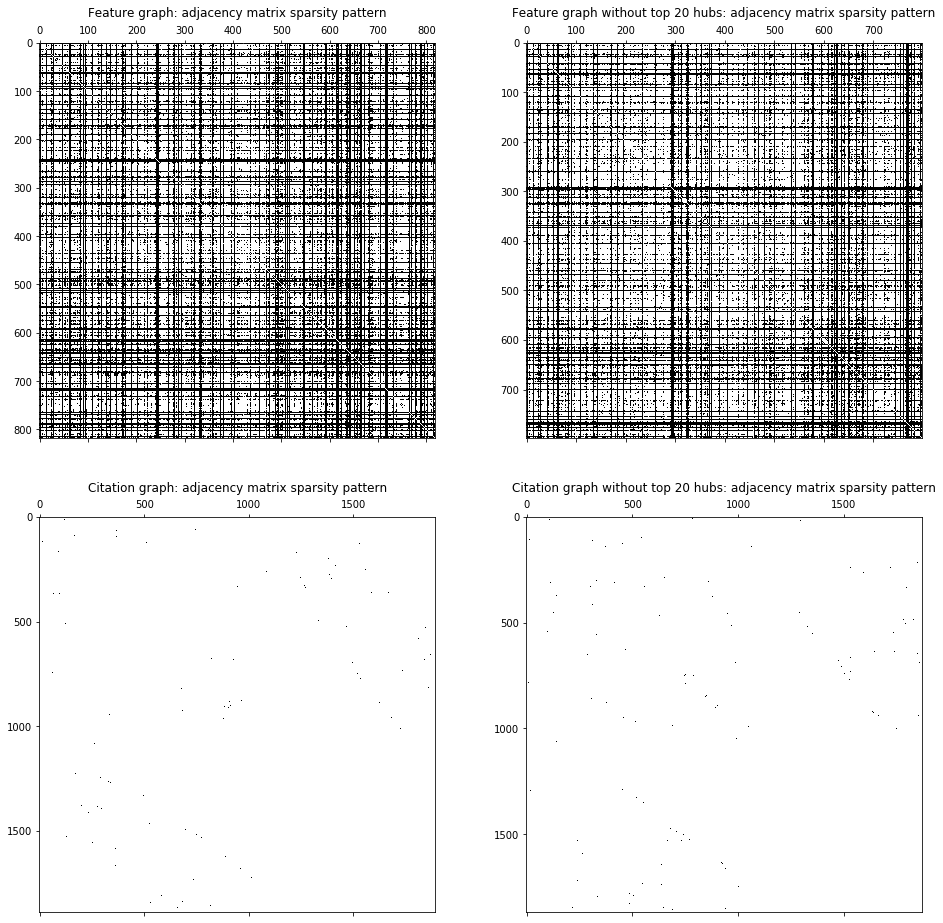

In [29]:
# TODO: 1. get the ids of the 20 largest hubs
# TODO: 2. prune the matrix of these ids
NUMBER_OF_HUBS = 20
ids_largest_hubs_citation = np.argpartition(degrees_citation, -NUMBER_OF_HUBS)[-NUMBER_OF_HUBS:]
ids_largest_hubs_feature = np.argpartition(degrees_feature, -NUMBER_OF_HUBS)[-NUMBER_OF_HUBS:]
reduced_A_feature = prune_ids_adjacency_matrix(A_feature, ids_largest_hubs_feature)
reduced_A_citation = prune_ids_adjacency_matrix(A_citation, ids_largest_hubs_citation)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

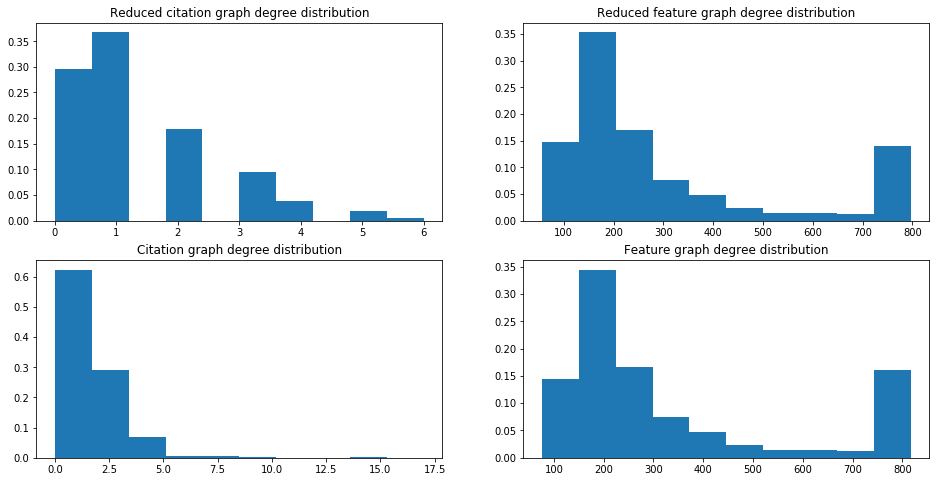

In [30]:
reduced_degrees_feat = compute_nodes_degrees(reduced_A_feature)
reduced_degrees_cit = compute_nodes_degrees(reduced_A_citation)

deg_hist_normalization_citation = np.ones(reduced_degrees_cit.shape[0])/reduced_degrees_cit.shape[0]
deg_hist_normalization_feature = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes[0,0].set_title('Reduced citation graph degree distribution')
axes[0,0].hist(reduced_degrees_cit, weights=deg_hist_normalization_citation);
axes[0,1].set_title('Reduced feature graph degree distribution')
axes[0,1].hist(reduced_degrees_feat, weights=deg_hist_normalization_feature);
axes[1,0].set_title('Citation graph degree distribution')
axes[1,0].hist(degrees_citation, weights=deg_hist_normalization_cit);
axes[1,1].set_title('Feature graph degree distribution')
axes[1,1].hist(degrees_feature, weights=deg_hist_normalization_feat);

Compute the first and second moments for the new graphs.

In [31]:
reduced_cit_moment_1 = compute_nth_moment(reduced_A_citation, 1)
reduced_cit_moment_2 = compute_nth_moment(reduced_A_citation, 2, center = reduced_cit_moment_1)

reduced_feat_moment_1 = compute_nth_moment(reduced_A_feature, 1)
reduced_feat_moment_2 = compute_nth_moment(reduced_A_feature, 2, center = reduced_feat_moment_1)


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.2898395721925133
Citation graph second moment: 1.554495696188052
Feature graph first moment:  302.28822055137846
Feature graph second moment:  50784.683846207


Print the number of edges in the reduced graphs.

In [32]:
num_edges_reduced_feature = count_edges(reduced_A_feature)
num_edges_reduced_citation = count_edges(reduced_A_citation)
print('Num edges in reduced... feature={} citation={}'.format(num_edges_reduced_feature,num_edges_reduced_citation))

Num edges in reduced... feature=120613.0 citation=1206.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

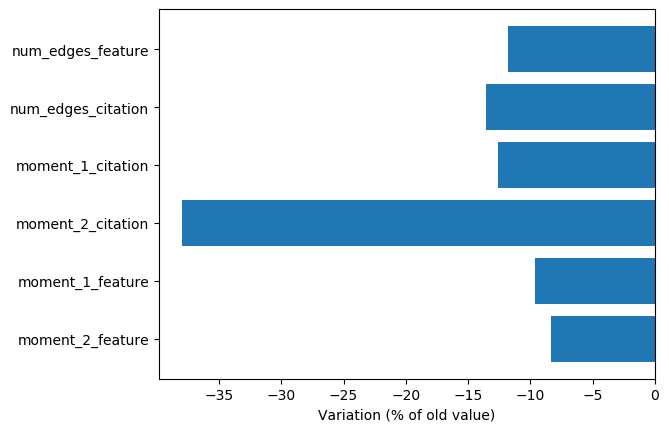

In [33]:
def show_variation(old_value, new_value, name = 'feature'):
    variation = (new_value-old_value)/old_value*100
    #print('{} varied by {}%'.format(name, variation))
    return name, variation
variations_params = [
    (num_edges_feature, num_edges_reduced_feature, 'num_edges_feature'),
    (num_edges_citation, num_edges_reduced_citation, 'num_edges_citation'),
    (cit_moment_1, reduced_cit_moment_1, 'moment_1_citation'),
    (cit_moment_2, reduced_cit_moment_2, 'moment_2_citation'),
    (feat_moment_1, reduced_feat_moment_1, 'moment_1_feature'),
    (feat_moment_2, reduced_feat_moment_2, 'moment_2_feature')
]
variations = [show_variation(a,b,c) for a,b,c in variations_params]
x, heights = unzip(variations)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(x))
ax.barh(y_pos, heights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Variation (% of old value)')
plt.show()

**Your answer here:**
The second moment of the citation graph is affected the most.

We could aslo argue that the citation graph is much smaller in terms of edges so removing a fix value of 20 hubs has more impact on this small graph than on the very huge feature graph.

### <span style="color:red">TODO: answer.check the question</span>

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [70]:
def dichotomic_search(min_param, max_param, expected_val, param_to_val, epsilon = 100, max_loops = 50):
    '''param_to_val should be a strctly increasing function of param on [min_param, max_param]'''
    test_param = (min_param+max_param)/2
    test_value = param_to_val(test_param)
    max_loops = max_loops - 1
    if max_loops == 0:
        print('WARNING: max_loops parameter exceeded -> dichotomic_search interrupted')
        return test_param
    if test_value < expected_val + epsilon and test_value > expected_val - epsilon:
        return test_param
    if test_value > expected_val:
        return dichotomic_search(min_param, test_param, expected_val, param_to_val, epsilon, max_loops)
    else:
        return dichotomic_search(test_param, max_param, expected_val, param_to_val, epsilon, max_loops)

In [72]:
threshold_2 = dichotomic_search(
    0,# zero is the lowest bound possible
    mean_distance,# we know that mean distance is already too much
    num_edges_citation,# that's our goal value (aka. number of edges in graph)
    lambda x: count_edges(clean_diagonal(binary_threshold_matrix(distance, x))),
    epsilon = 5
)
print(f"Optimal threshold is {threshold_2}")

A_feature_pruned = clean_diagonal(binary_threshold_matrix(distance, threshold_2))
num_edges_feature_pruned = count_edges(A_feature_pruned)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Optimal threshold is 2.9999999999999956
Number of edges in the feature graph: 136763.0
Number of edges in the feature graph after pruning: 1378.0
Number of edges in the citation graph: 1395.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

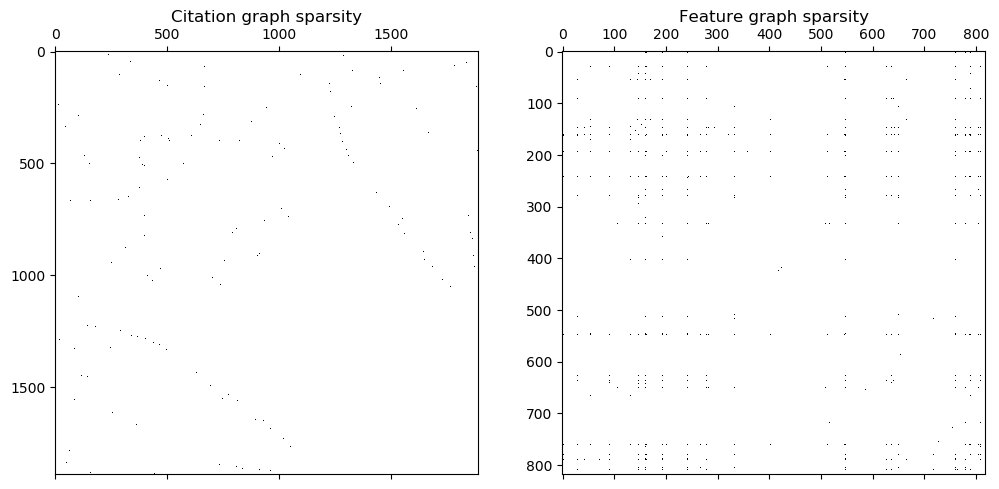

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [74]:
def compute_N_path_matrix(adjacency_matrix, N):
    return np.linalg.matrix_power(adjacency_matrix, N)

N = 10
path_matrix_citation = compute_N_path_matrix(A_citation, N)
path_matrix_feature = compute_N_path_matrix(A_feature, N)

Check the sparsity pattern for both of path matrices.

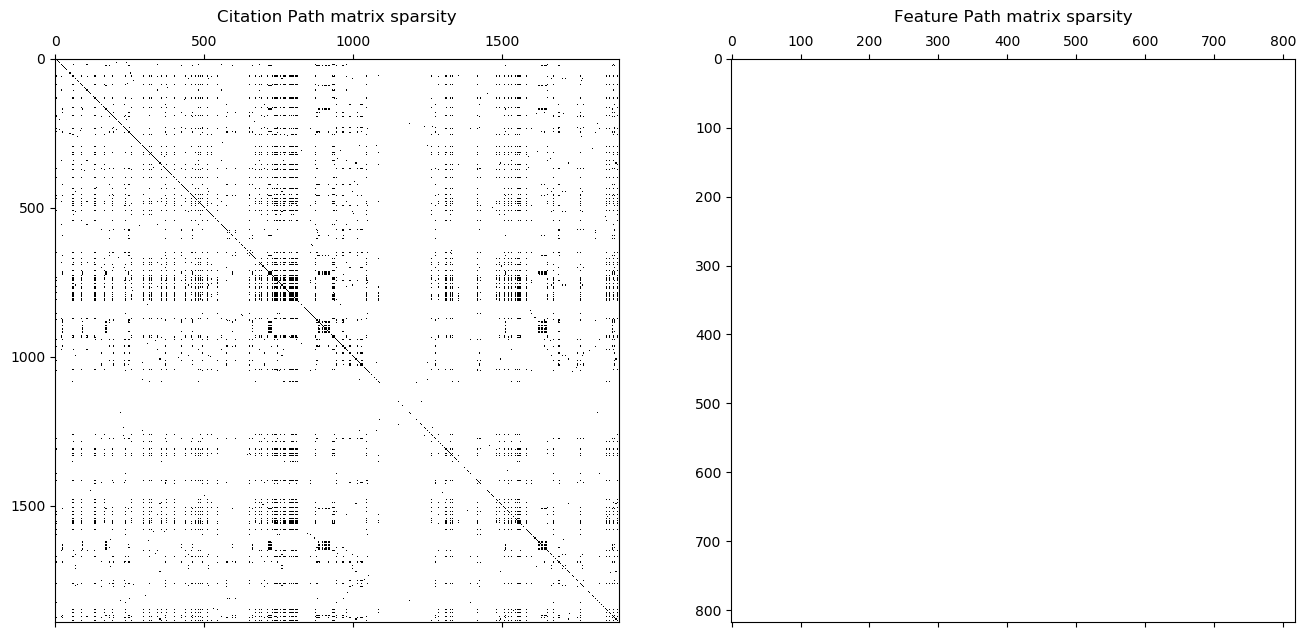

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

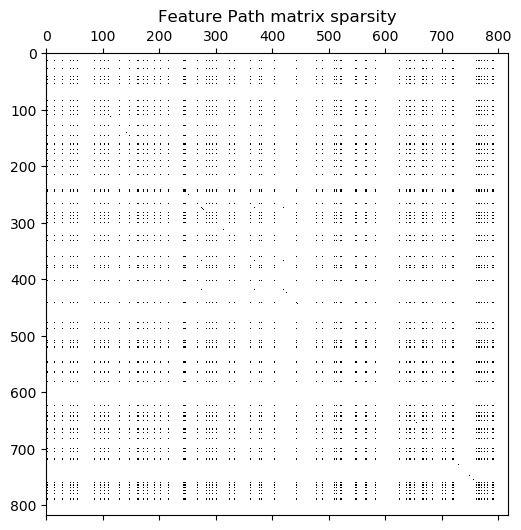

In [78]:
path_matrix_pruned = compute_N_path_matrix(A_feature_pruned, N)

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**     

## <span style="color:red">TODO: answer the question</span>
(Not sure I get what we should observe)

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:**    
We can fix a N max and accumulates number of n (for n <= N) paths. In the end, the path-matrix should not have zeros values if it is connected.

### <span style="color:red">TODO: answer.check the question</span>

In [101]:
def get_matrix_connectivity(adjacency_matrix, N_max = 50, next_n = 1, output_logs = False):
    ''' returns -1 if not connected or the diameter if connected '''
    path_matrix = compute_N_path_matrix(adjacency_matrix, next_n)
    if np.count_nonzero(path_matrix==0) == 0:
        if output_logs:
            print(f"Matrix is connected with paths of max {next_n} step(s)")
        return next_n
    if next_n == N_max:
        if output_logs:
            print(f"Matrix is not connected")
            print(f"WARNING: connectivity has been checked for maximum {N_max}-step path")
        return -1
    return get_matrix_connectivity(adjacency_matrix, N_max, next_n + 1, output_logs)

def is_matrix_connected(adjacency_matrix, N_max = 50, next_n = 1, output_logs = False):
    return get_matrix_connectivity(adjacency_matrix, N_max, next_n, output_logs) != -1

In [103]:
print("Checking feature (unpruned) connectivity...")
is_matrix_connected(A_feature, output_logs = True)

Checking feature (unpruned) connectivity...
Matrix is connected with paths of max 2 step(s)


True

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**    
The previous code already answers this question. We check for which n (of N) the matrix has now paths from any node to any node.

### <span style="color:red">TODO: answer.check the question</span>

If any of your graphs is connected, calculate the diameter using that process.

In [104]:
diameter = get_matrix_connectivity(A_feature)
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [105]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [ ]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [ ]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [ ]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [ ]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [ ]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:**

In [ ]:
p = # Your code here.
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [ ]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:**

In [ ]:
q = # Your code here.
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [ ]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [ ]:
giant_citation = # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

In [ ]:
giant_feature = # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

Check the size of the giant components in the generated Erdős–Rényi graph.

In [ ]:
giant_er = # Your code here.
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

In [ ]:
p_new = # Your code here.
G_er_new = nx.erdos_renyi_graph(n, p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [ ]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = # Your code here.
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = # Your code here.
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**

Now, plot the degree distribution historgrams for the simulated networks.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = # Your code here.
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = # Your code here.
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = # Your code here.
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** 

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [ ]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** 

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [ ]:
nx.average_clustering(G_citation)

In [ ]:
nx.average_clustering(G_feature)

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:**

Now, let us check the average clustering coefficient for the simulated networks.

In [ ]:
nx.average_clustering(G_er)

In [ ]:
nx.average_clustering(G_ba)

In [ ]:
nx.average_clustering(nx.Graph(G_config))

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:**

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [ ]:
# Your code here.

Comment on the similarities of your match.

**Your answer here:**